# Sawyer Jacobson
## Data Science Capstone, Final Project
## Using Machine Learning to Predict NHL Game Outcomes

### 5/22/2021

This project will use data scraped from the NHL statsapi on the overall team and player levels to predict the outcome of regular season NHL games. 
This is a binary classification problem so the appropriate algorithms will be used. I am particularly interested in obtaining the probability of 
winning for a team in the game. The target for predictions will be whether or not the home team won/will win and the associated probabilities.

In [44]:
import pandas as pd
import numpy as np
from plotnine import *
import plotnine
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import scipy
from sklearn import metrics
import sklearn as sk
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [45]:
player_stats = pd.read_csv("data/game_player_stats.csv")
goalie_stats = pd.read_csv("data/game_goalie_stats.csv")
game_results = pd.read_csv("data/game_results.csv")
team_stats_game = pd.read_csv("data/game_team_stats.csv")
officials_game = pd.read_csv("data/game_officials.csv")

player_stats.shape
goalie_stats.shape
game_results.shape
team_stats_game.shape
officials_game.shape

(419064, 27)

(25078, 24)

(11790, 11)

(23577, 18)

(46569, 3)

## Exploratory data analysis

First we'll check to see that all the data game in in the proper format. Some of the player ice time columns will need to be fixed using the function used for the player analysis project.

Also check to see what data is missing. Since I collected the data in a specific manner, missing data should be just the absence of data and in most cases will mean 0, False, whatever is the appropriate base case for that type of variable.

Since our interest is in the game data, let's see how the games are distributed in terms of results and scoring.

In [139]:
pd.set_option("max_info_columns", player_stats.shape[1])
pd.set_option("max_columns", player_stats.shape[1])

# checking the data types of each column to see what else needs to be cleaned
player_stats.info()
goalie_stats.info()
game_results.info()
team_stats_game.info()
officials_game.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419064 entries, 0 to 419063
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   gameID                419064 non-null  object 
 1   playerID              419064 non-null  object 
 2   fullName              419064 non-null  object 
 3   position              419064 non-null  object 
 4   homeAway              419064 non-null  object 
 5   teamID                419064 non-null  object 
 6   teamName              419064 non-null  object 
 7   timeOnIce             419064 non-null  float64
 8   assists               419064 non-null  int64  
 9   goals                 419064 non-null  int64  
 10  shots                 419064 non-null  int64  
 11  hits                  419064 non-null  int64  
 12  powerPlayGoals        419064 non-null  int64  
 13  powerPlayAssists      419064 non-null  int64  
 14  penaltyMinutes        419064 non-null  int64  
 15  

Looks like everythink actually came in pretty clean! The time on ice variables need to be fixed as expected, but everything else came through nicely!

In [7]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct'],
      dtype='object')

In [107]:
# function to clean the time on ice from minutes:seconds format to a decimal
def clean_toi(x):
    time = x.str.split(":")
    minutes = time.str.get(0)
    seconds = time.str.get(1).astype(int)*100/60
    return minutes + "." + seconds.round().astype(int).astype(str)

time_on_ice_cols = ['timeOnIce', 'powerPlayTimeOnIce', 'evenTimeOnIce', 'shortHandedTimeOnIce']
# had to change the clean_toi function a few times because the list wasn't working right...
player_stats[time_on_ice_cols] = player_stats[time_on_ice_cols].apply(clean_toi).astype(float)

In [47]:
game_results.head()

,gameID,season,gameType,homeTeamID,homeTeamName,awayTeamID,awayTeamName,homeGoals,awayGoals,homeTeamWin,venue
0,2010020001,20102011,R,10,Toronto Maple Leafs,8,Montréal Canadiens,3,2,True,Air Canada Centre
1,2010020002,20102011,R,5,Pittsburgh Penguins,4,Philadelphia Flyers,2,3,False,CONSOL Energy Center
2,2010020003,20102011,R,30,Minnesota Wild,12,Carolina Hurricanes,3,4,False,Hartwall Areena
3,2010020004,20102011,R,21,Colorado Avalanche,16,Chicago Blackhawks,4,3,True,Pepsi Center
4,2010020005,20102011,R,22,Edmonton Oilers,20,Calgary Flames,4,0,True,Rexall Place


True     0.536387
False    0.463613
Name: homeTeamWin, dtype: float64

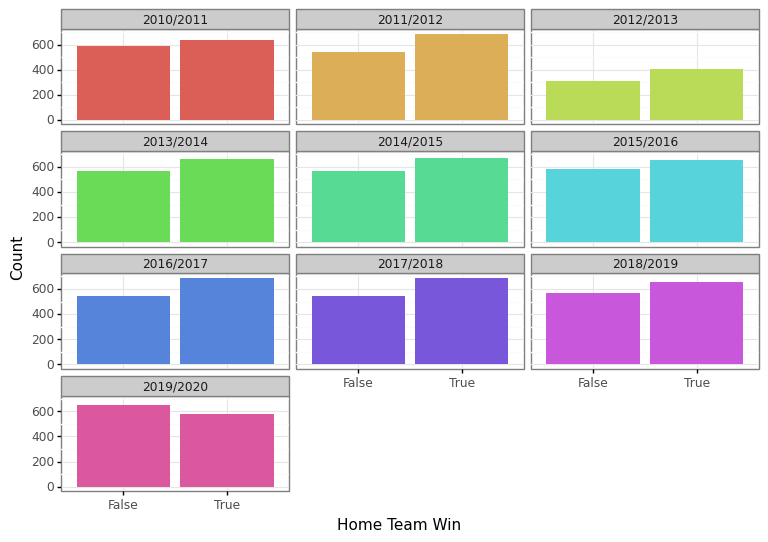

<ggplot: (357174634)>

In [48]:
# percentage of games where the home team won
game_results.homeTeamWin.value_counts()/game_results.shape[0]

def add_season(df):
    return df['gameID'].astype(str).str[0:4] + "/" + (df['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

# adding a season column
game_results["season"] = add_season(game_results)#game_results['gameID'].astype(str).str[0:4] + "/" + (game_results['gameID'].astype(str).str[0:4].astype(int) + 1).astype(str)

plotnine.options.figure_size = (9, 6)

(
ggplot(game_results, aes(x = "homeTeamWin", fill = 'season')) + 
    geom_bar() + 
    theme_bw() + 
    facet_wrap(" ~ season", ncol = 3) +
    scale_fill_discrete(guide=False) +
    labs(x = "Home Team Win", y = "Count")
)

In [49]:
pd.crosstab(index=game_results['season'], columns=game_results['homeTeamWin'])

homeTeamWin,False,True
season,,
2010/2011,592,638
2011/2012,543,687
2012/2013,311,409
2013/2014,570,660
2014/2015,564,666
2015/2016,579,651
2016/2017,542,688
2017/2018,541,689
2018/2019,571,659


In almost every season from the past decade, the home team has won a slight majority of the games. The 2019/2020 season seemed to be the exception, potentially due to the season being delayed and cut short because of COVID-19.

Below, we'll create a new dataset that has a teams cumulative statistics throughout a season. These stats will be used as features in the predictive model. The difference between 2 teams cumulative stats up to the desired game in a season will be used (home team - away team) which should help determine which team is doing better in that season as well as a certain difference in performance. I intend to include other features such as whether the starter goalie has played consecutive games or not and also take into account the roster for each team. This last feature will be something of a pseudo roster strength going into the game. Theoretically this should help because the roster strength would be diminished if a star player was out hurt or something.

In [50]:
team_stats_game['season'] = add_season(team_stats_game)

In [103]:
ID_cols = team_stats_game.filter(like="ID").columns.to_list()

team_stats_game[ID_cols] = team_stats_game[ID_cols].astype(str)
team_stats_game.drop(columns="periodsPlayed", inplace=True)
team_num_vars = team_stats_game.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_team_num_stats = team_stats_game \
    .groupby(by=['teamID', 'season'])[team_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_team_stats = pd.concat([team_stats_game.drop(columns=team_num_vars), cum_team_num_stats], axis="columns")

In [104]:
cum_team_stats

,gameID,homeAway,homeTeamWin,headCoach,teamID,teamName,season,goals,pim,shots,powerPlayPercentage,powerPlayGoals,powerPlayOpportunities,faceOffWinPercentage,blocked,takeaways,giveaways,hits
0,2010020001,home,True,Ron Wilson,10,Toronto Maple Leafs,2010/2011,3,6,24,0.0,0.0,5.0,46.5,22,6,16,27
1,2010020001,away,True,Jacques Martin,8,Montréal Canadiens,2010/2011,2,10,28,0.0,0.0,3.0,53.5,21,7,7,34
2,2010020002,home,False,Dan Bylsma,5,Pittsburgh Penguins,2010/2011,2,10,31,20.0,1.0,5.0,60.7,14,9,11,32
3,2010020002,away,False,Peter Laviolette,4,Philadelphia Flyers,2010/2011,3,12,27,25.0,1.0,4.0,39.3,16,1,9,34
4,2010020003,home,False,Todd Richards,30,Minnesota Wild,2010/2011,3,10,29,40.0,2.0,5.0,61.2,19,8,11,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23572,2019021228,away,False,D.J. Smith,9,Ottawa Senators,2019/2020,190,682,2174,1036.5,30.0,211.0,3563.8,1070,448,749,1979
23573,2019021229,home,False,Barry Trotz,2,New York Islanders,2019/2020,189,575,2016,1120.2,29.0,168.0,3390.6,1153,485,947,1915
23574,2019021229,away,False,Dean Evason,30,Minnesota Wild,2019/2020,218,560,2077,1491.1,46.0,216.0,3334.2,968,442,464,1121
23575,2019021230,home,False,Mike Sullivan,5,Pittsburgh Penguins,2019/2020,221,517,2204,1447.5,42.0,211.0,3372.1,892,520,634,1884


Here, the same process will be used to create a cumulative player stats dataset for each season.

In [121]:
player_stats["season"] = add_season(player_stats)
player_stats["gamesPlayed"] = 1
player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]] = player_stats[['faceoffTaken', "faceOffWins", "faceOffPct"]].fillna(value=0)
player_ID_cols = player_stats.filter(like="ID").columns.to_list()

player_stats[player_ID_cols] = player_stats[player_ID_cols].astype(str)
player_num_vars = player_stats.select_dtypes(include = ['float64', 'int64']).columns.to_list()

# creating cumulative totals for the 
cum_player_num_stats = player_stats \
    .groupby(by=['playerID', 'season'])[player_num_vars] \
    .cumsum()
# creating the full cumulative team stats dataframe
cum_player_stats = pd.concat([player_stats.drop(columns=player_num_vars), cum_player_num_stats], axis="columns")

In [140]:
cum_player_stats

,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,timeOnIce,assists,goals,shots,hits,powerPlayGoals,powerPlayAssists,penaltyMinutes,faceOffWins,faceoffTaken,takeaways,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed
0,2010020001,8468778,Colton Orr,R,home,10,Toronto Maple Leafs,2010/2011,3.32,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,3.32,0.00,0.00,0.00,1
1,2010020001,8470602,Dion Phaneuf,D,home,10,Toronto Maple Leafs,2010/2011,23.75,1,0,2,2,0,0,2,0,0,0,1,0,0,3,1,15.18,6.78,1.78,0.00,1
2,2010020001,8465200,Tomas Kaberle,D,home,10,Toronto Maple Leafs,2010/2011,23.92,0,0,2,1,0,0,0,0,0,0,0,0,0,2,0,16.27,7.65,0.00,0.00,1
3,2010020001,8467400,Francois Beauchemin,D,home,10,Toronto Maple Leafs,2010/2011,22.35,0,0,1,3,0,0,0,0,0,1,2,0,0,3,0,15.70,3.42,3.23,0.00,1
4,2010020001,8474125,Carl Gunnarsson,D,home,10,Toronto Maple Leafs,2010/2011,17.55,0,0,1,1,0,0,0,0,0,1,3,0,0,2,1,13.32,1.47,2.77,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419059,2019021082,8478469,Thomas Chabot,D,away,9,Ottawa Senators,2019/2020,1849.07,33,6,186,79,0,11,42,0,0,42,87,0,0,85,-18,1599.77,233.27,19.48,0.00,71
419060,2019021082,8477963,Jayce Hawryluk,R,away,9,Ottawa Senators,2019/2020,289.16,7,3,26,65,0,0,16,4,12,11,12,0,0,9,1,285.67,4.27,0.40,300.00,26
419061,2019021082,8478870,Rudolfs Balcers,L,away,9,Ottawa Senators,2019/2020,183.54,2,1,23,19,0,0,0,0,2,7,5,0,0,7,-2,159.19,26.07,0.00,0.00,15
419062,2019021082,8476285,Matthew Peca,C,away,9,Ottawa Senators,2019/2020,146.19,2,0,7,15,0,0,0,43,79,0,1,0,0,4,-4,138.00,1.48,8.78,619.38,14


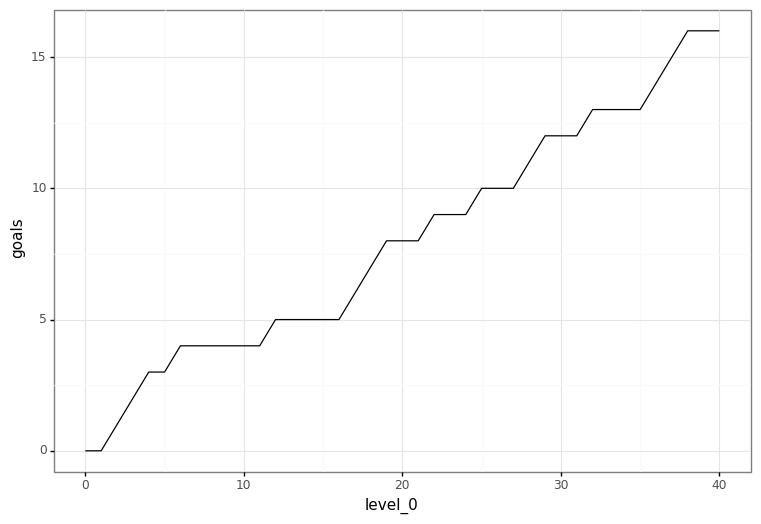

<ggplot: (355495876)>

In [146]:
(
ggplot(cum_player_stats.query("fullName == 'Sidney Crosby' & season == '2019/2020'").reset_index().reset_index(), aes(x = "level_0", y = "goals")) + 
    geom_line() + 
    theme_bw()
)

In [126]:
cum_player_stats.query("fullName == 'Sidney Crosby'").reset_index().reset_index()

,level_0,index,gameID,playerID,fullName,position,homeAway,teamID,teamName,season,...,giveaways,shortHandedGoals,shortHandedAssists,blocked,plusMinus,evenTimeOnIce,powerPlayTimeOnIce,shortHandedTimeOnIce,faceOffPct,gamesPlayed
0,0,47,2010020002,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2010/2011,...,0,0,0,0,-1,16.20,7.43,1.25,62.07,1
1,1,550,2010020016,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2010/2011,...,2,0,0,0,-2,29.97,14.10,2.57,116.24,2
2,2,961,2010020027,8471675,Sidney Crosby,C,away,5,Pittsburgh Penguins,2010/2011,...,6,0,0,0,0,43.94,21.57,2.84,174.13,3
3,3,1373,2010020039,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2010/2011,...,6,0,0,0,0,60.42,24.95,4.64,236.63,4
4,4,1769,2010020050,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2010/2011,...,6,0,0,1,-1,73.22,34.33,5.57,296.63,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,603,416874,2019021022,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2019/2020,...,21,0,0,16,-6,606.96,136.04,13.40,2026.08,37
604,604,417285,2019021033,8471675,Sidney Crosby,C,away,5,Pittsburgh Penguins,2019/2020,...,21,0,0,16,-6,623.14,139.24,13.40,2071.08,38
605,605,417879,2019021050,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2019/2020,...,21,0,0,16,-7,638.94,145.94,13.50,2135.08,39
606,606,418203,2019021059,8471675,Sidney Crosby,C,home,5,Pittsburgh Penguins,2019/2020,...,25,0,0,16,-8,651.17,152.67,13.50,2215.08,40


In [116]:
player_stats.columns

Index(['gameID', 'playerID', 'fullName', 'position', 'homeAway', 'teamID',
       'teamName', 'timeOnIce', 'assists', 'goals', 'shots', 'hits',
       'powerPlayGoals', 'powerPlayAssists', 'penaltyMinutes', 'faceOffWins',
       'faceoffTaken', 'takeaways', 'giveaways', 'shortHandedGoals',
       'shortHandedAssists', 'blocked', 'plusMinus', 'evenTimeOnIce',
       'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'faceOffPct', 'season'],
      dtype='object')